In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from matplotlib import cm
import seaborn as sns
import sqlite3
from datetime import datetime
import squarify 
from scipy.stats import f_oneway

In [2]:
merged_data = pd.read_csv('merged_data.csv')
merged_data.head()

,userid,day,hour,minute,touch_screen_events,week,what,withw,Extraversion,Openness,Conscientiousness,Neuroticism,Agreeableness,gender,department,age
0,1,20201113,0,0,58,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
1,1,20201113,0,30,30,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
2,1,20201113,8,0,9,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
3,1,20201113,9,0,286,Friday,Eating,with_others,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
4,1,20201113,10,0,897,Friday,Work/Study,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23


In [3]:
len(merged_data.userid.unique())

189

I start the sql queries, using a new connector as the previous one stored an older version of merged_data.

In [4]:
conn = sqlite3.connect('project_sdl_2.db')
cur = conn.cursor()

In [5]:
merged_data.to_sql('merged_data', conn)

ValueError: Table 'merged_data' already exists.

In [6]:
%load_ext sql
%sql sqlite:///project_sdl.db

In [7]:
%sql
cur.execute("SELECT hour, minute, AVG(touch_screen_events), COUNT(minute) FROM merged_data m GROUP BY m.hour, m.minute")
rows = cur.fetchall()

 * sqlite:///project_sdl.db


Data is now summed up by the hour and minute, which enables me to showcase daily trends.

In [8]:
touch_by_hour = pd.DataFrame(rows, columns =['hour', 'minute','avg_touch_screen_events', 'occurrences'])
touch_by_hour['time'] = touch_by_hour['hour'].astype(str)+'.'+touch_by_hour['minute'].astype(str)

In [9]:
touch_by_hour['time'] =  touch_by_hour['time'].astype(float)
x =touch_by_hour['time'] 
x2 = list()
for j in x:
    if int(j) != j:
        j += 0.2
        x2.append(j)
    else:
        x2.append(j)
touch_by_hour['time_r'] = x2
#Rescale occurrences.
touch_by_hour['occurrences'] = (touch_by_hour['occurrences'] - min(touch_by_hour['occurrences'])) / (max(touch_by_hour['occurrences']) - min(touch_by_hour['occurrences']))
touch_by_hour['weight'] = touch_by_hour.avg_touch_screen_events * touch_by_hour.occurrences 
touch_by_hour.to_csv('touch_by_hour.csv', index=False)

In [10]:
touch_by_hour.head()

,hour,minute,avg_touch_screen_events,occurrences,time,time_r,weight
0,0,0,248.071493,0.835637,0.0,0.0,207.297837
1,0,30,258.424051,0.527650,0.3,0.5,136.357391
2,1,0,235.650146,0.376728,1.0,1.0,88.776034
3,1,30,268.711304,0.202381,1.3,1.5,54.382050
4,2,0,242.204938,0.137097,2.0,2.0,33.205516


In [11]:
touch_by_hour = pd.read_csv('touch_by_hour.csv')

Now we that our data has the appropriate format it's time for plots.

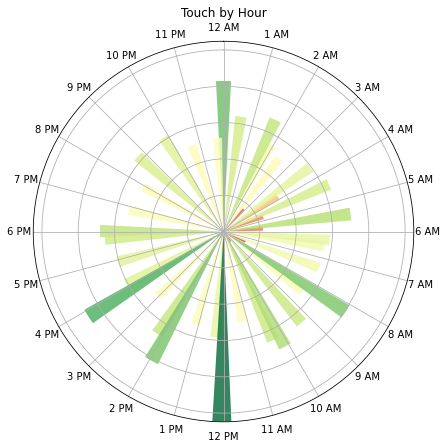

In [12]:
my_cmap = plt.get_cmap("RdYlGn")
x = touch_by_hour['time_r']
y = touch_by_hour['weight']
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, projection = 'polar')

ax.bar(x, y, width = 0.1, alpha=0.8, color=my_cmap(rescale(y)))

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)

ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))

ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM','8 AM','9 AM','10 AM','11 AM','12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
ax.set_xticklabels(ticks)

plt.setp(ax.get_yticklabels(), visible=False)

plt.ylim(0,max(touch_by_hour['weight']))
plt.title('Touch by Hour')
#plt.legend(bbox_to_anchor=(1,0), fancybox=True, shadow=True)
plt.show()

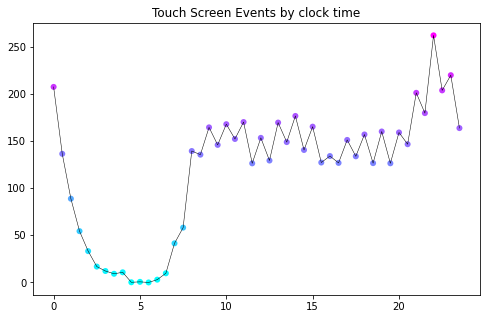

In [13]:
x= touch_by_hour['time_r']
y = touch_by_hour['weight']

plt.figure(figsize=(8,5))
labels = x
plt.scatter(x,y, c=cm.cool(y/y.max()), edgecolor='none')
plt.plot(x,y, c='black', linewidth=0.5, label=touch_by_hour['time'])
#plt.xticks(np.arange(6), ['12 AM', '4 AM', '8 AM', '12 PM', '4 PM', '8 PM'])

plt.title('Touch Screen Events by clock time')
plt.show()

I want to see if there are any weekly trends as well. This requires a new SQL queries which discriminates data by the weekday.

!!! REPEAT BUT START BY 7 AM!!

In [14]:
%sql
cur.execute("SELECT week, hour, minute, AVG(touch_screen_events), COUNT(minute) FROM merged_data m GROUP BY m.hour, m.minute, m.week")
rows2 = cur.fetchall()

 * sqlite:///project_sdl.db


In [15]:
touch_by_hour_week = pd.DataFrame(rows2, columns =['Weekday', 'hour','minute','avg_touch_screen_events', 'occurrences'])
touch_by_hour_week['time']=touch_by_hour_week['hour'].astype(str)+'.'+touch_by_hour_week['minute'].astype(str)

touch_by_hour_week['time'] =  touch_by_hour_week['time'].astype(float)
x =touch_by_hour_week['time'] 
x2 = list()
for j in x:
    if int(j) != j:
        j += 0.2
        x2.append(j)
    else:
        x2.append(j)
touch_by_hour_week['time_r'] = x2

#Again, rescaled.
touch_by_hour_week['occurrences'] = (touch_by_hour_week['occurrences'] - min(touch_by_hour_week['occurrences'])) / (max(touch_by_hour_week['occurrences']) - min(touch_by_hour_week['occurrences']))
touch_by_hour_week['weight'] = touch_by_hour_week.avg_touch_screen_events * touch_by_hour_week.occurrences 
o = pd.CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday'],ordered=True)
touch_by_hour_week['sort']=pd.Series(touch_by_hour_week.Weekday, dtype=o)
touch_by_hour_week.sort_values(by=['sort','time_r'],inplace=True)
touch_by_hour_week.head()

,Weekday,hour,minute,avg_touch_screen_events,occurrences,time,time_r,weight,sort
1,Monday,0,0,259.198758,0.679406,0.0,0.0,176.101067,Monday
8,Monday,0,30,215.633540,0.337580,0.3,0.5,72.793488,Monday
15,Monday,1,0,287.342657,0.299363,1.0,1.0,86.019776,Monday
22,Monday,1,30,302.612903,0.127389,1.3,1.5,38.549414,Monday
29,Monday,2,0,257.285714,0.084926,2.0,2.0,21.850167,Monday


In [16]:
touch_by_hour_week.to_csv('touch_by_hour_week.csv', index=False)

In [17]:
days = list(touch_by_hour_week.Weekday.unique())
days

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [18]:
touch_by_hour_week

,Weekday,hour,minute,avg_touch_screen_events,occurrences,time,time_r,weight,sort
1,Monday,0,0,259.198758,0.679406,0.0,0.0,176.101067,Monday
8,Monday,0,30,215.633540,0.337580,0.3,0.5,72.793488,Monday
15,Monday,1,0,287.342657,0.299363,1.0,1.0,86.019776,Monday
22,Monday,1,30,302.612903,0.127389,1.3,1.5,38.549414,Monday
29,Monday,2,0,257.285714,0.084926,2.0,2.0,21.850167,Monday
...,...,...,...,...,...,...,...,...,...
304,Sunday,21,30,210.585670,0.677282,21.3,21.5,142.625963,Sunday
311,Sunday,22,0,288.889952,0.883227,22.0,22.0,255.155457,Sunday
318,Sunday,22,30,249.623494,0.700637,22.3,22.5,174.895442,Sunday
325,Sunday,23,0,239.027950,0.679406,23.0,23.0,162.396909,Sunday


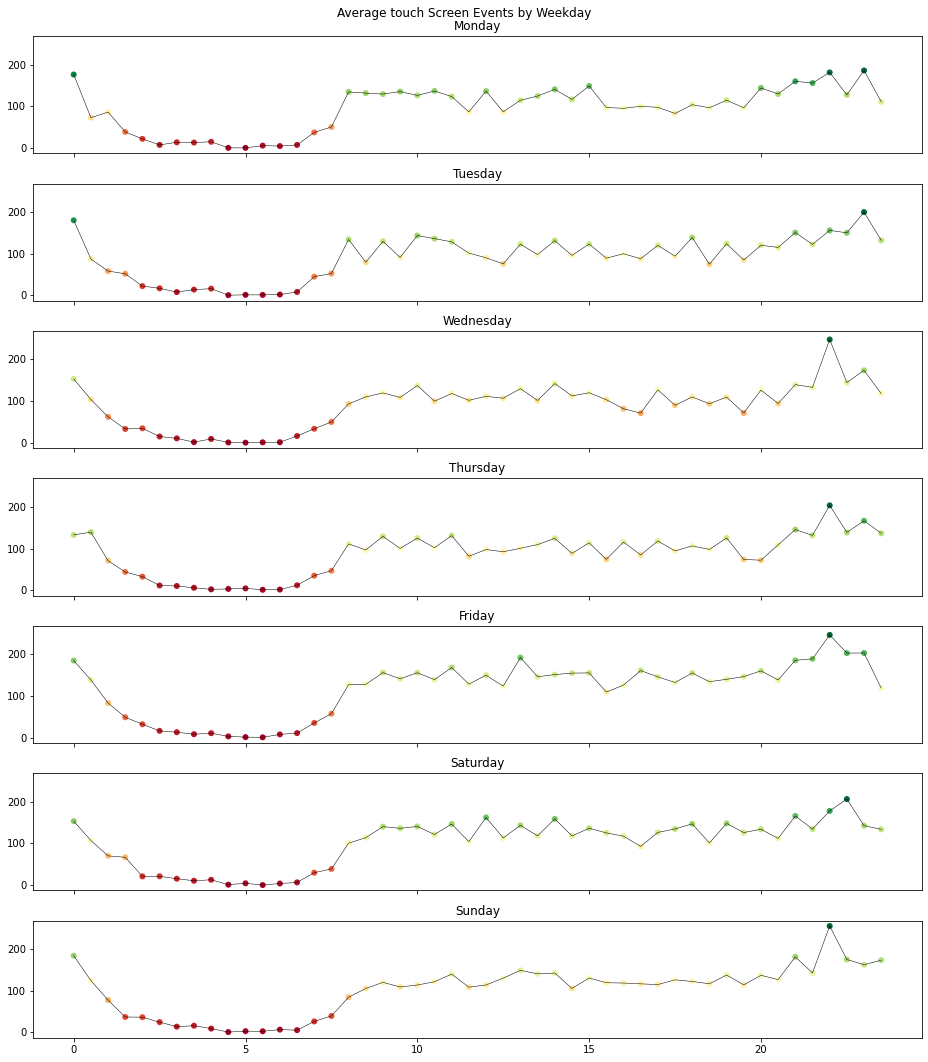

In [19]:
plt.rcParams["figure.figsize"] = (13,15)

fig, axs = plt.subplots(7, sharex=True, sharey=True)
i = 0

fig.suptitle('Average touch Screen Events by Weekday')
for j in days:
    day_data = touch_by_hour_week[touch_by_hour_week.Weekday==j]
    x= day_data['time_r']
    y= day_data['weight']
    axs[i].scatter(x,y, c=cm.RdYlGn(y/y.max()), edgecolor='none')
    axs[i].plot(x,y, c='black', linewidth=0.5)
    axs[i].set_title(j)
    #plt.locator_params(axis='x', nbins=10)
    i+=1

fig.tight_layout()
plt.savefig("daily_trends.jpg") 
plt.show()

In [29]:
merged_data.head()

,userid,day,hour,minute,touch_screen_events,week,what,withw,Extraversion,Openness,Conscientiousness,Neuroticism,Agreeableness,gender,department,age
0,1,20201113,0,0,58,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
1,1,20201113,0,30,30,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
2,1,20201113,8,0,9,Friday,Other,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
3,1,20201113,9,0,286,Friday,Eating,with_others,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23
4,1,20201113,10,0,897,Friday,Work/Study,Alone,100.0,75.0,31.25,75.0,100.0,Female,Humanities,23


In [20]:
%sql
cur.execute("SELECT what, 2*AVG(touch_screen_events), COUNT(what)/2 FROM merged_data m GROUP BY what")
rowsa = cur.fetchall()

 * sqlite:///project_sdl.db


By only taking half the activities I already count the number of hours.
I want to plot activities by the number of touch screen per hour.

In [172]:
touch_by_activity = pd.DataFrame(rowsa, columns =['Activity', 'touch_per_hour','occurrences'])
touch_by_activity

,Activity,touch_per_hour,occurrences
0,Chores,417.332102,1353
1,Computer/TV/Phone,494.058462,4960
2,Eating,434.430313,5126
3,Free Time,442.257296,5208
4,Hobby & Culture,407.222194,2000
5,Other,353.534865,3721
6,Rest,476.692355,3270
7,Social life,445.267765,1850
8,Travel,393.827398,1193
9,Work/Study,368.748146,7887


In [178]:
touch_by_activity = touch_by_activity.sort_values(by=["touch_per_hour"], ascending=False).reset_index(drop=True)
touch_by_activity.to_csv('touch_by_activity.csv', index=False)

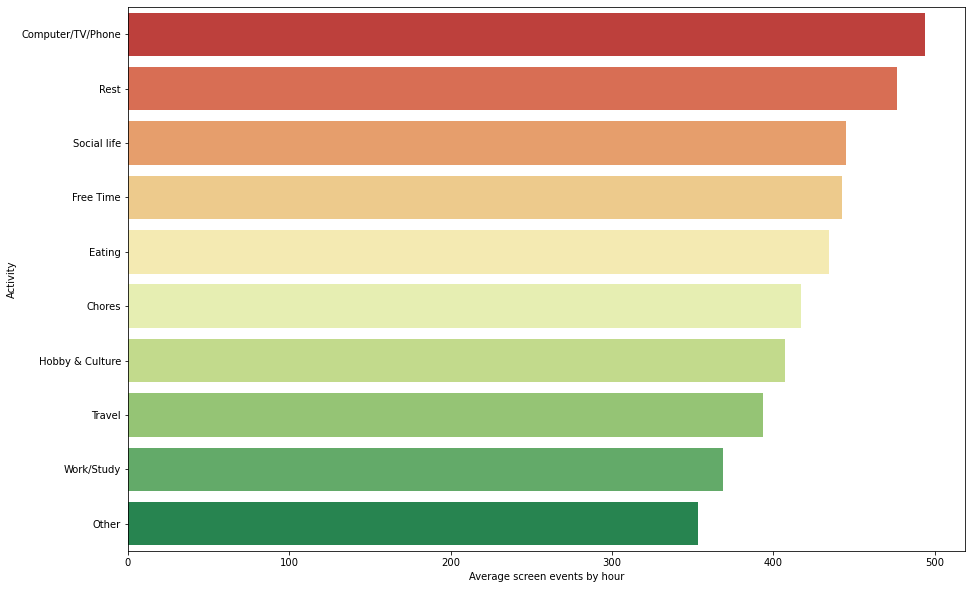

In [23]:
fig = plt.figure(figsize = (15, 10))
g = sns.barplot(data=touch_by_activity, x="touch_per_hour", y="Activity", palette='RdYlGn')
#g.set(ylim=(1500, 2500))
plt.savefig('activity touch screen average.jpg')
plt.xlabel('Average screen events by hour')
plt.show()

In [24]:
%sql
cur.execute("SELECT userid, SUM(touch_screen_events), count(touch_screen_events)/2 FROM merged_data m GROUP BY userid")
rows_id = cur.fetchall()

 * sqlite:///project_sdl.db


In [25]:
rows_id

[(1, 155604, 251),
 (2, 107607, 168),
 (3, 130294, 353),
 (4, 53693, 198),
 (5, 128051, 277),
 (6, 71480, 169),
 (7, 28665, 73),
 (8, 116838, 269),
 (9, 110810, 311),
 (10, 18674, 43),
 (12, 83879, 188),
 (13, 52425, 273),
 (15, 113060, 214),
 (18, 119462, 250),
 (19, 110295, 240),
 (20, 177437, 262),
 (21, 41265, 197),
 (22, 48787, 180),
 (23, 21399, 94),
 (26, 64951, 277),
 (27, 39, 1),
 (28, 66151, 170),
 (29, 28022, 68),
 (30, 59120, 308),
 (31, 56648, 143),
 (32, 143513, 204),
 (33, 70654, 270),
 (34, 182788, 312),
 (36, 7766, 10),
 (41, 50665, 92),
 (42, 54369, 155),
 (43, 28941, 103),
 (45, 99339, 298),
 (46, 6606, 16),
 (48, 121534, 221),
 (49, 78464, 130),
 (50, 187449, 302),
 (51, 45119, 132),
 (52, 25198, 148),
 (55, 106808, 259),
 (57, 106424, 281),
 (58, 124701, 175),
 (59, 155256, 332),
 (61, 37005, 119),
 (62, 45654, 210),
 (65, 51702, 269),
 (66, 195332, 260),
 (67, 14746, 33),
 (70, 138943, 265),
 (72, 42134, 113),
 (73, 78407, 173),
 (74, 101083, 203),
 (75, 199225, 3

In [174]:
touch_by_id = pd.DataFrame(rows_id, columns =['userid', 'total_touch_screen_events', 'hours'])
touch_by_id['hour_average'] = touch_by_id['total_touch_screen_events']/touch_by_id['hours']
touch_by_id = touch_by_id.sort_values(by=["hour_average"], ascending=False).reset_index(drop=True)
pd.set_option('mode.use_inf_as_na', True)
touch_by_id.dropna(inplace=True)
touch_by_id.to_csv('touch_by_id.csv', index=False)

In [10]:
touch_by_id = pd.read_csv('touch_by_id.csv')
touch_by_id.head()

,userid,total_touch_screen_events,hours,hour_average
0,116,8813,7,1259.000000
1,264,214792,231,929.835498
2,165,115306,139,829.539568
3,125,44555,54,825.092593
4,36,7766,10,776.600000


Since one resulted to be infinite I excluded all rows which reported infinite.
Now, my data will be split in three even groups.

In [11]:
group = []

for i in range(len(touch_by_id)):
    if i < len(touch_by_id)/3:
        group.append('Group 1')
    elif i < 2*len(touch_by_id)/3:
        group.append('Group 2')
    else:
        group.append('Group 3')

In [12]:
touch_by_id['group'] = group

I want to only describe these users, so I merge the data with the already recoded sociodemographic dataframe.

In [13]:
individuals = pd.read_csv('individuals.csv')

In [14]:
individuals.head()

,userid,Extraversion,Openness,Conscientiousness,Neuroticism,Agreeableness,gender,department,age
0,0,68.75,87.50,93.75,50.00,87.50,Female,Engineering and Applied Sciences,24
1,1,100.00,75.00,31.25,75.00,100.00,Female,Humanities,23
2,10,62.50,87.50,62.50,37.50,81.25,Male,Agricultural,20
3,100,18.75,50.00,81.25,6.25,87.50,Female,Social Sciences,19
4,101,50.00,56.25,62.50,18.75,68.75,Female,Law,24


In [15]:
touch_by_id = pd.merge(touch_by_id, individuals, left_on=['userid'], right_on=['userid'], how='inner')

In [16]:
touch_by_id.head()

,userid,total_touch_screen_events,hours,hour_average,group,Extraversion,Openness,Conscientiousness,Neuroticism,Agreeableness,gender,department,age
0,116,8813,7,1259.000000,Group 1,37.5,68.75,93.75,25.00,75.00,Male,Business/economics,31+
1,264,214792,231,929.835498,Group 1,100.0,93.75,68.75,37.50,93.75,Female,Law,20
2,165,115306,139,829.539568,Group 1,37.5,68.75,81.25,75.00,75.00,Female,Engineering and Applied Sciences,23
3,125,44555,54,825.092593,Group 1,NaN,NaN,NaN,68.75,NaN,Male,Agricultural,20
4,36,7766,10,776.600000,Group 1,87.5,56.25,43.75,50.00,87.50,Female,Law,24


In [109]:
touch_by_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   userid                     188 non-null    int64  
 1   total_touch_screen_events  188 non-null    int64  
 2   hours                      188 non-null    int64  
 3   hour_average               188 non-null    float64
 4   group                      188 non-null    int64  
 5   Extraversion               186 non-null    float64
 6   Openness                   187 non-null    float64
 7   Conscientiousness          187 non-null    float64
 8   Neuroticism                187 non-null    float64
 9   Agreeableness              187 non-null    float64
 10  gender                     188 non-null    object 
 11  department                 187 non-null    object 
 12  age                        188 non-null    object 
dtypes: float64(6), int64(4), object(3)
memory usage: 2

I plot the box plot for each of the big 5 personality traits within each of the 3 groups.

In [7]:
touch_by_id = pd.read_csv('touch_by_id.csv')

In [18]:
touch_by_id = touch_by_id.dropna()

In [19]:
Group_1 = touch_by_id[touch_by_id.group=='Group 1']
Group_2 = touch_by_id[touch_by_id.group=='Group 2']
Group_3 = touch_by_id[touch_by_id.group=='Group 3'] 

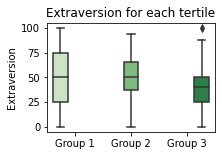

In [20]:
fig = plt.figure(figsize = (3,2))
ax = sns.boxplot(y='Extraversion', x='group',  hue='group',data=touch_by_id, palette="Greens")
plt.legend([],[],frameon=False)
ax.set(xlabel=None)
plt.title('Extraversion for each tertile')
plt.savefig('Extraversion.jpg')
plt.show()

In [21]:
f_oneway(list(Group_1.Extraversion), list(Group_2.Extraversion), list(Group_3.Extraversion))

F_onewayResult(statistic=2.6893849173286712, pvalue=0.07063714264888497)

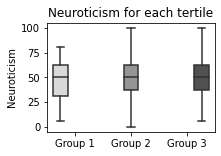

In [27]:
fig = plt.figure(figsize = (3,2))
ax = sns.boxplot(y='Neuroticism', x='group',  data=touch_by_id, palette="Greys",
                 hue='group')
plt.legend([],[],frameon=False)
ax.set(xlabel=None)
plt.title('Neuroticism for each tertile')
plt.savefig('Neuroticism.jpg')
plt.show()

In [22]:
f_oneway(list(Group_1.Neuroticism), list(Group_2.Neuroticism), list(Group_3.Neuroticism))

F_onewayResult(statistic=1.3077379258629342, pvalue=0.27297379641814634)

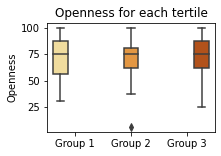

In [28]:
fig = plt.figure(figsize = (3,2))
ax = sns.boxplot(y='Openness', x='group',  data=touch_by_id, palette="YlOrBr",
                 hue='group')
plt.legend([],[],frameon=False)
ax.set(xlabel=None)
plt.title('Openness for each tertile')
plt.savefig('Openness.jpg')
plt.show()

In [23]:
f_oneway(list(Group_1.Openness), list(Group_2.Openness), list(Group_3.Openness))

F_onewayResult(statistic=0.07188025847255529, pvalue=0.930668877829576)

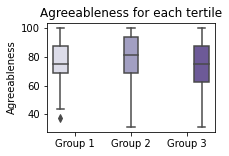

In [29]:
fig = plt.figure(figsize = (3,2))
ax = sns.boxplot(y='Agreeableness', x='group',  data=touch_by_id, palette="Purples",
                 hue='group')
plt.legend([],[],frameon=False)
ax.set(xlabel=None)
plt.title('Agreeableness for each tertile')
plt.savefig('Agreeableness.jpg')
plt.show()

In [24]:
f_oneway(list(Group_1.Agreeableness), list(Group_2.Agreeableness), list(Group_3.Agreeableness))

F_onewayResult(statistic=1.2574191610659773, pvalue=0.286859174331112)

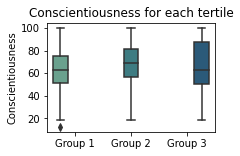

In [30]:
fig = plt.figure(figsize = (3,2))
ax = sns.boxplot(y='Conscientiousness', x='group',  data=touch_by_id, palette="crest",
                 hue='group')
plt.legend([],[],frameon=False)
ax.set(xlabel=None)
plt.title('Conscientiousness for each tertile')
plt.savefig('Conscientiousness.jpg')
plt.show()

In [25]:
f_oneway(list(Group_1.Conscientiousness), list(Group_2.Conscientiousness), list(Group_3.Conscientiousness))

F_onewayResult(statistic=0.4715157431933381, pvalue=0.624820002591717)

In [22]:
grouped = touch_by_id.groupby(['group', 'gender'])
grouped.size()

group    gender
Group 1  Female    38
         Male      25
Group 2  Female    38
         Male      25
Group 3  Female    35
         Male      27
dtype: int64

There seem to be no trends involving gender, the distribution is equal; do note that more females participated in the data collection, hence why the higher number in all categories.

Now, a two-way table of departments divided by groups, but first I recode the names.

In [57]:
touch_by_id.department = touch_by_id.department.replace({"Business/economics": "Business", "Medicine and veterinary medicine": "Medicine ",
                                                        'International Relations and Public Administration':'International Relations'})

In [58]:
grouped = touch_by_id.groupby(['department', 'group'])
grouped.size()

department                        group
Agricultural                      1         1
                                  2         1
Business                          1         8
                                  2         7
                                  3         8
Engineering and Applied Sciences  1        11
                                  2        18
                                  3        15
Humanities                        1         6
                                  2         4
                                  3         6
International Relations           2         1
                                  3         1
Law                               1        10
                                  2         6
                                  3         9
Medicine                          1         3
                                  2         3
Natural Sciences                  1         5
                                  2         9
                                  3     

In [5]:
touch_by_id.to_csv('touch_by_id.csv', index=False)
#touch_by_id = pd.read_csv('touch_by_id.csv')

NameError: name 'touch_by_id' is not defined